## Setup, Loading Data and CDFs

In [22]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'red'

In [23]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_wavelet_full_pastis.ipynb


In [24]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/red'

In [25]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [26]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [27]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


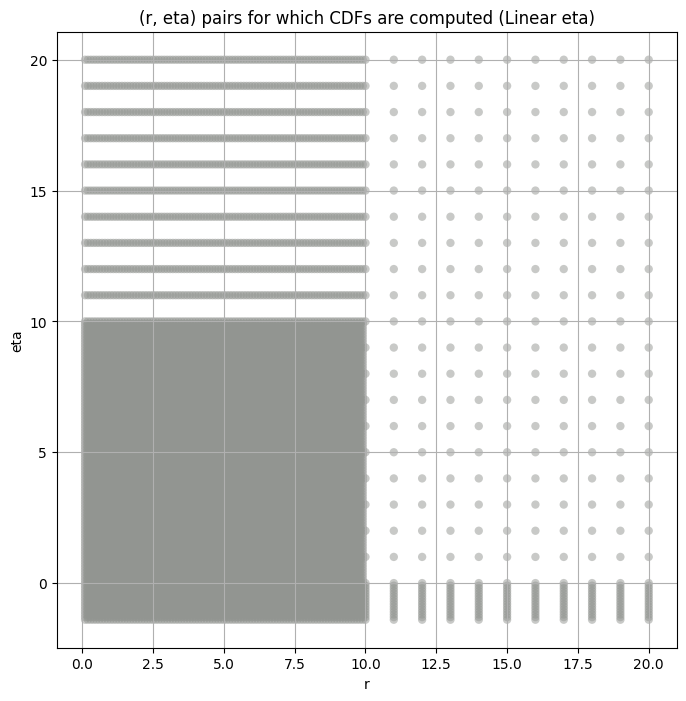

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [28]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [29]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [30]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:36<00:00, 2756.68it/s]


Layer 3


100%|██████████| 100000/100000 [00:49<00:00, 2020.18it/s]


Layer 4


100%|██████████| 100000/100000 [00:44<00:00, 2267.62it/s]


Layer 5


100%|██████████| 100000/100000 [00:44<00:00, 2237.62it/s]


Layer 6


100%|██████████| 100000/100000 [00:48<00:00, 2041.27it/s]


Layer 7


100%|██████████| 100000/100000 [00:46<00:00, 2163.97it/s]


Layer 8


100%|██████████| 100000/100000 [00:52<00:00, 1916.47it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,1905.932900,1698.254500,2134.568000,4.313463,2.497993,6.197537,3180.0
3,610.390870,574.298700,648.551900,3.674140,2.805851,4.680453,12720.0
4,172.283200,161.497960,183.496800,4.112916,3.268325,5.234512,50880.0
5,40.234180,37.397793,43.230920,5.987719,4.644133,7.689358,203520.0
6,8.033402,7.378767,8.728930,8.447668,6.249308,11.777606,814080.0
7,1.504845,1.368442,1.653126,11.570850,8.417268,17.668781,3256320.0
8,0.248263,0.222952,0.278427,16.534340,10.476642,35.571274,13025280.0


## Initial Grid Search and Hypothesis Test Plots

In [31]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [32]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,1905.932900,1905.932861,1457.897461,1273.488037,1133.268188,1024.188477,858.920654,729.934326,627.437744,541.681396,471.144897,313.765656
3,610.390870,610.390869,553.593933,521.707642,496.366455,474.836426,439.439453,410.678070,386.120697,364.704742,345.673523,298.925720
4,172.283200,172.283203,166.450684,162.441055,159.109634,156.193329,151.000076,146.387436,142.260468,138.519745,135.099625,126.260376
5,40.234180,40.234180,39.178448,38.452030,37.846001,37.296528,36.353901,35.537895,34.796398,34.115540,33.486008,31.836966
6,8.033402,8.033401,7.764287,7.592730,7.449450,7.323658,7.105913,6.918346,6.751371,6.599819,6.460675,6.096578
7,1.504845,1.504845,1.444392,1.406544,1.375331,1.348077,1.301000,1.260613,1.224870,1.192641,1.163147,1.086971
8,0.248263,0.248263,0.235332,0.227992,0.222080,0.216983,0.208348,0.201040,0.194633,0.188897,0.183682,0.170342


####
Layer  2


100%|██████████| 12760/12760 [00:02<00:00, 4651.16it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.01960099603216159 1905.9329


100%|██████████| 12760/12760 [00:01<00:00, 7257.56it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.019748095048523318 1457.8975


100%|██████████| 12760/12760 [00:01<00:00, 7548.18it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.028663070146193292 1273.488


100%|██████████| 12760/12760 [00:01<00:00, 7186.66it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.03726548228909421 1133.2682


100%|██████████| 12760/12760 [00:01<00:00, 7387.46it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.04529930603181809 1024.1885


100%|██████████| 12760/12760 [00:02<00:00, 6163.53it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.060471056967849046 858.92065


100%|██████████| 12760/12760 [00:02<00:00, 4921.39it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.07624076565848392 729.9343


100%|██████████| 12760/12760 [00:01<00:00, 6481.81it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.09005900719873428 627.43774


100%|██████████| 12760/12760 [00:02<00:00, 5938.85it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.10368928552652157 541.6814


100%|██████████| 12760/12760 [00:02<00:00, 4311.27it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.11862341033411739 471.1449


100%|██████████| 12760/12760 [00:02<00:00, 4802.37it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.15717517827228444 313.76566
Number of samples: 3180, Without approximation : 3180.0


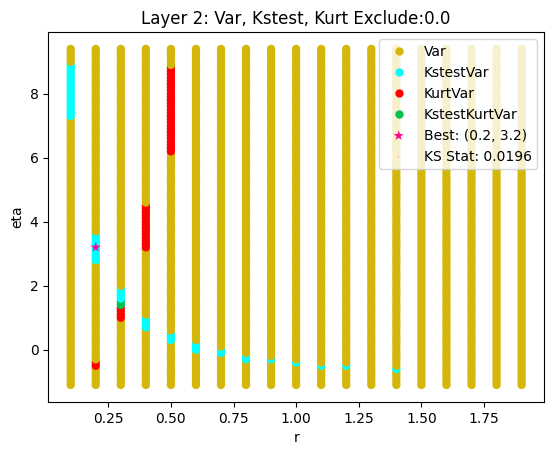

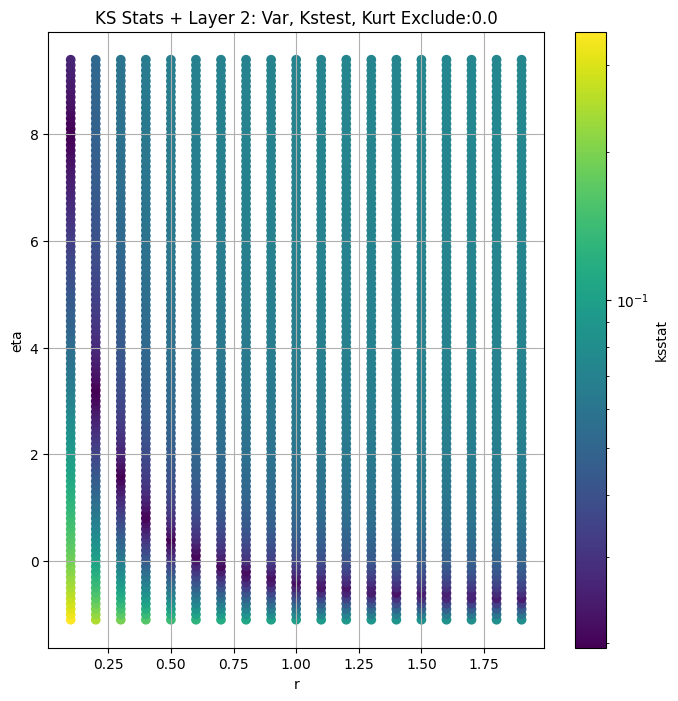

####
Layer  3


100%|██████████| 12760/12760 [00:06<00:00, 1898.54it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.0031506821694508025 610.39087


100%|██████████| 12760/12760 [00:06<00:00, 1912.09it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.00507969693799637 553.59393


100%|██████████| 12760/12760 [00:07<00:00, 1797.40it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.0072258743470782205 521.70764


100%|██████████| 12760/12760 [00:07<00:00, 1711.60it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.009544000612822234 496.36646


100%|██████████| 12760/12760 [00:07<00:00, 1761.06it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.011457486989251198 474.83643


100%|██████████| 12760/12760 [00:05<00:00, 2128.41it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.016116683915336605 439.43945


100%|██████████| 12760/12760 [00:07<00:00, 1610.86it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.021050478049534416 410.67807


100%|██████████| 12760/12760 [00:07<00:00, 1807.34it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.025444442408381174 386.1207


100%|██████████| 12760/12760 [00:05<00:00, 2185.35it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.02973569789857189 364.70474


100%|██████████| 12760/12760 [00:05<00:00, 2139.41it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.03392080199128633 345.67352


100%|██████████| 12760/12760 [00:06<00:00, 2106.49it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.04500897709766172 298.92572
Number of samples: 12720, Without approximation : 12720.0


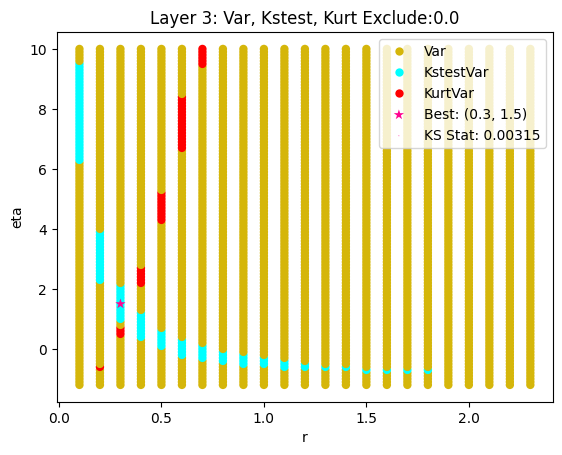

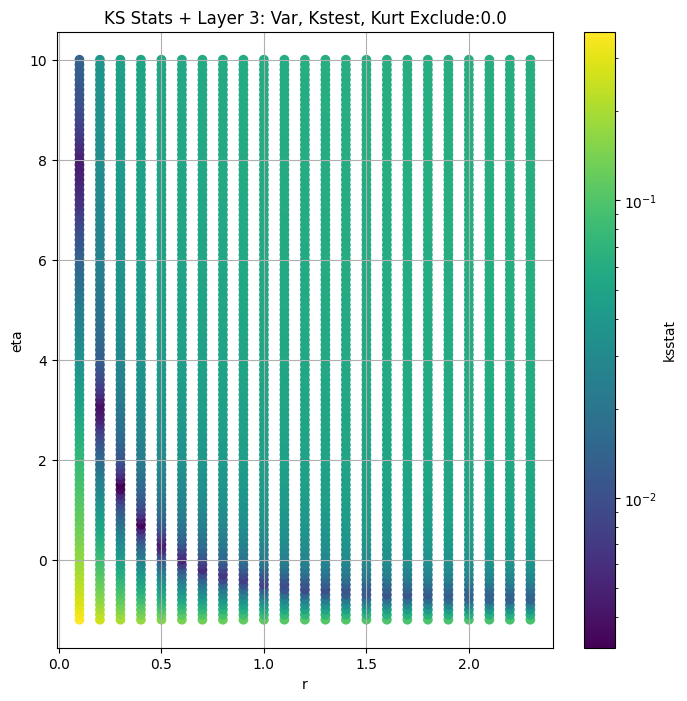

####
Layer  4


100%|██████████| 12760/12760 [00:23<00:00, 544.71it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.005797027872469995 172.2832


100%|██████████| 12760/12760 [00:23<00:00, 536.16it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.0055694458241813405 166.45068


100%|██████████| 12760/12760 [00:27<00:00, 462.54it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.0060257733006877645 162.44106


100%|██████████| 12760/12760 [00:27<00:00, 456.37it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.005801263192136363 159.10963


100%|██████████| 12760/12760 [00:25<00:00, 510.08it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.006245099139492227 156.19333


100%|██████████| 12760/12760 [00:24<00:00, 528.17it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.006871483042781734 151.00008


100%|██████████| 12760/12760 [00:22<00:00, 562.40it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.00816914336636887 146.38744


100%|██████████| 12760/12760 [00:22<00:00, 559.73it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.009269246262842423 142.26047


100%|██████████| 12760/12760 [00:22<00:00, 569.26it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010334122083899944 138.51974


100%|██████████| 12760/12760 [00:26<00:00, 487.49it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011388920552554693 135.09962


100%|██████████| 12760/12760 [00:22<00:00, 566.13it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.014463235513145656 126.260376
Number of samples: 50880, Without approximation : 50880.0


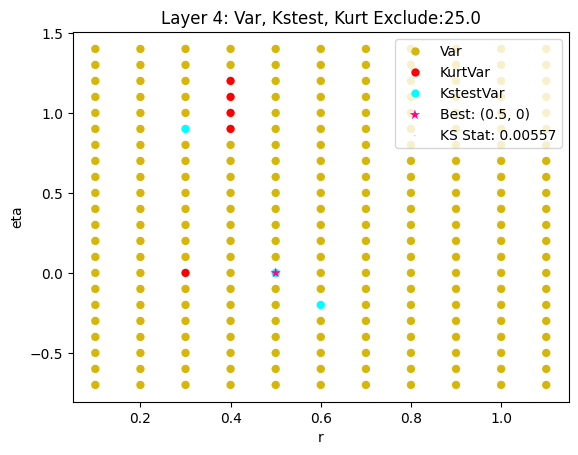

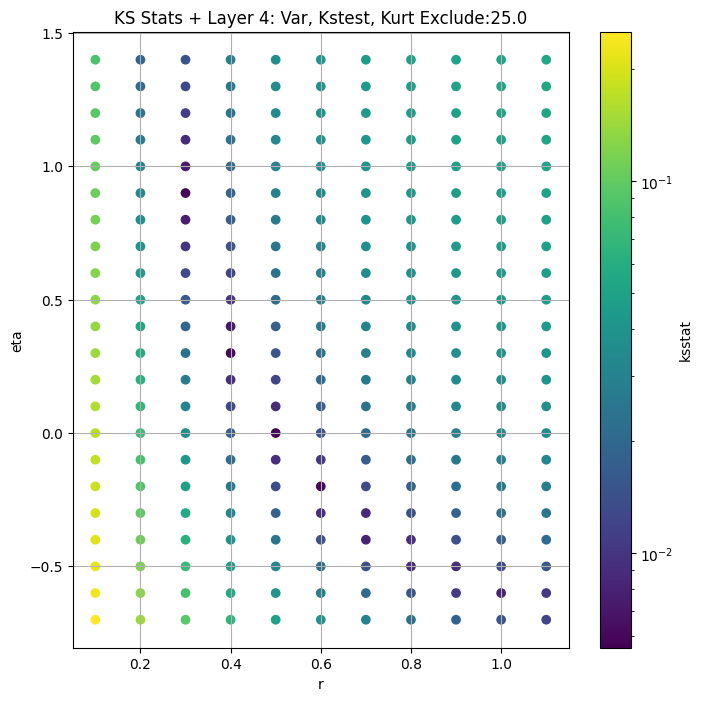

####
Layer  5


100%|██████████| 12760/12760 [00:47<00:00, 269.10it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.0034825008200942698 40.23418


100%|██████████| 12760/12760 [00:46<00:00, 273.64it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.0032652352571690413 39.178448


100%|██████████| 12760/12760 [00:44<00:00, 288.28it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.002663156988417792 38.45203


100%|██████████| 12760/12760 [00:43<00:00, 291.47it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.003189203685163511 37.846


100%|██████████| 12760/12760 [00:47<00:00, 265.98it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.003911746879449951 37.296528


100%|██████████| 12760/12760 [00:43<00:00, 295.49it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.003930962501705992 36.3539


100%|██████████| 12760/12760 [00:44<00:00, 285.83it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.004664786721373049 35.537895


100%|██████████| 12760/12760 [00:49<00:00, 256.99it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.005354692853420828 34.7964


100%|██████████| 12760/12760 [00:47<00:00, 266.31it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.00587824816308391 34.11554


100%|██████████| 12760/12760 [00:46<00:00, 272.30it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.006475896748478593 33.486008


100%|██████████| 12760/12760 [00:46<00:00, 277.31it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008261688763542385 31.836966
Number of samples: 100000, Without approximation : 203520.0


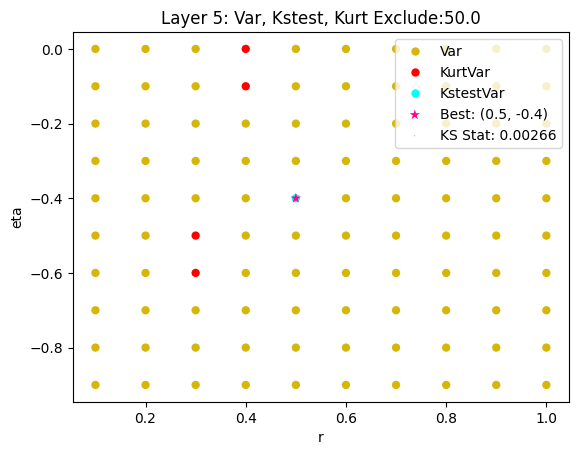

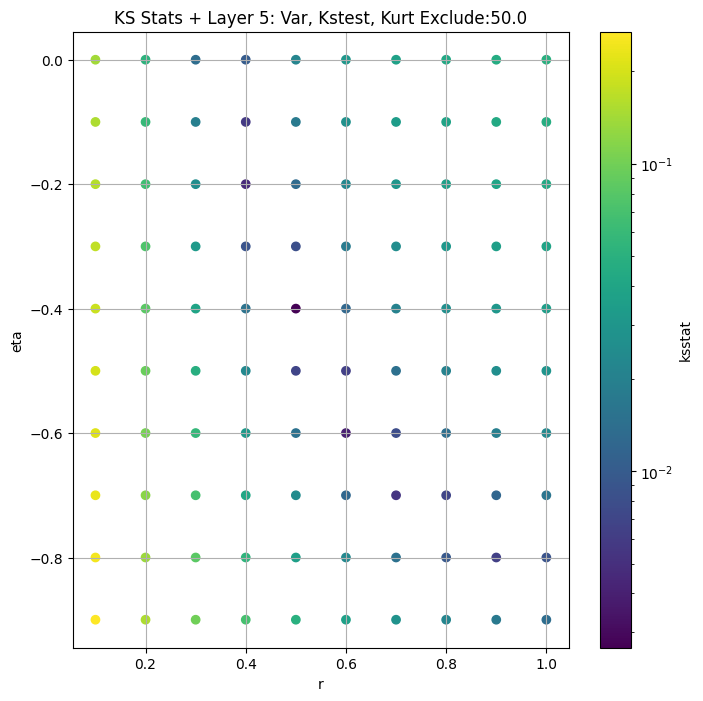

####
Layer  6


100%|██████████| 12760/12760 [00:45<00:00, 279.13it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.004726984272178325 8.0334015


100%|██████████| 12760/12760 [00:44<00:00, 285.51it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.0038826389579164067 7.764287


100%|██████████| 12760/12760 [00:46<00:00, 276.06it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.0038486088689406728 7.59273


100%|██████████| 12760/12760 [00:46<00:00, 272.42it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.00444036423187355 7.4494505


100%|██████████| 12760/12760 [00:44<00:00, 289.39it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.005347498588441191 7.3236575


100%|██████████| 12760/12760 [00:44<00:00, 286.16it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.006185632912217742 7.105913


100%|██████████| 12760/12760 [00:44<00:00, 284.95it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.006041429722884906 6.918346


100%|██████████| 12760/12760 [00:52<00:00, 241.64it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.005814916410635584 6.7513714


100%|██████████| 12760/12760 [00:48<00:00, 260.97it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.00662959805372576 6.5998187


100%|██████████| 12760/12760 [00:45<00:00, 278.24it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.006880087910785759 6.460675


100%|██████████| 12760/12760 [00:45<00:00, 277.95it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.0087141922112568 6.0965776
Number of samples: 100000, Without approximation : 814080.0


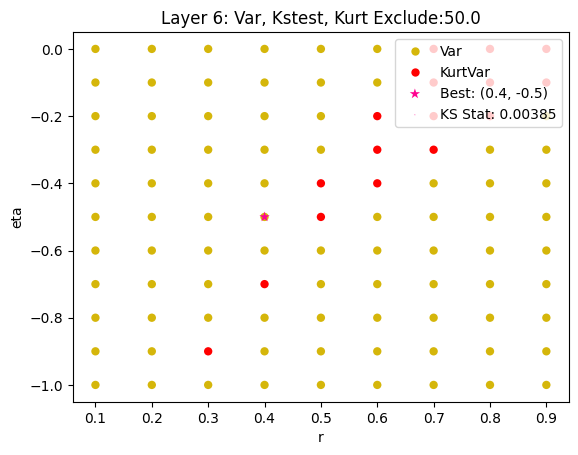

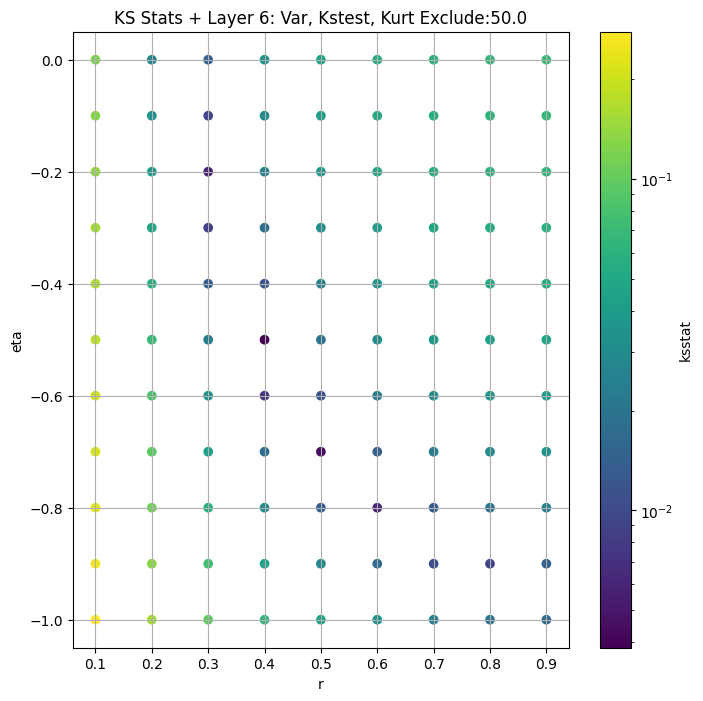

####
Layer  7


100%|██████████| 12760/12760 [00:43<00:00, 295.34it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.004634082901676995 1.5048453


100%|██████████| 12760/12760 [00:42<00:00, 299.52it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.006120023815553877 1.4443918


100%|██████████| 12760/12760 [00:43<00:00, 295.37it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.006397735155514672 1.4065442


100%|██████████| 12760/12760 [00:43<00:00, 295.79it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.006972701205144094 1.3753308


100%|██████████| 12760/12760 [00:43<00:00, 291.31it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.006187418223171259 1.3480766


100%|██████████| 12760/12760 [00:43<00:00, 295.31it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.006952994344320063 1.3009996


100%|██████████| 12760/12760 [00:44<00:00, 287.59it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.008072492526735031 1.2606132


100%|██████████| 12760/12760 [00:43<00:00, 296.21it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.0072595153717121 1.2248703


100%|██████████| 12760/12760 [00:42<00:00, 297.61it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.008302748564423923 1.1926414


100%|██████████| 12760/12760 [00:43<00:00, 291.87it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.009343682852501756 1.1631474


100%|██████████| 12760/12760 [00:43<00:00, 296.14it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.009804688642713666 1.0869714
Number of samples: 100000, Without approximation : 3256320.0


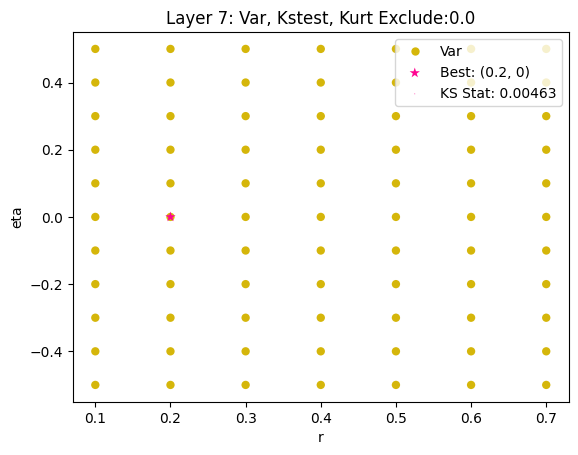

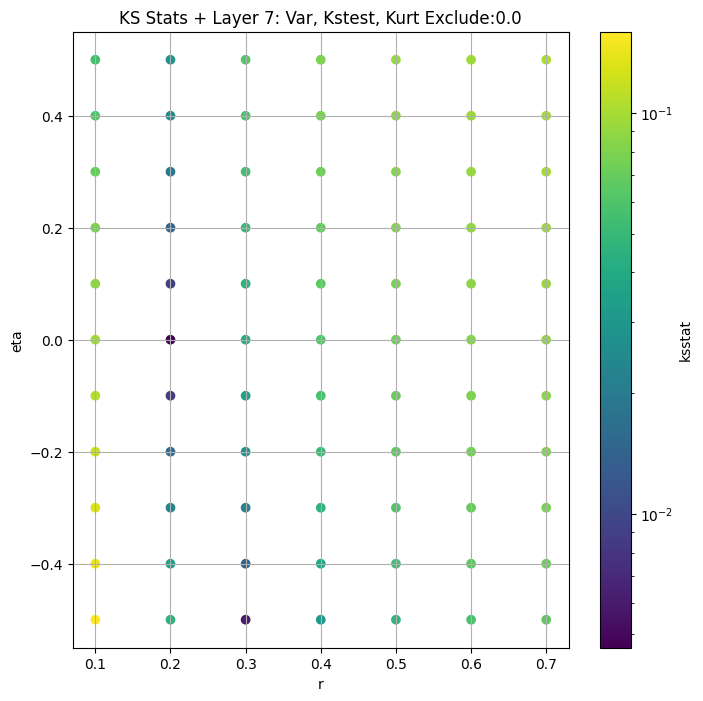

####
Layer  8


100%|██████████| 12760/12760 [00:42<00:00, 298.55it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.006023068390572817 0.24826278


100%|██████████| 12760/12760 [00:43<00:00, 296.11it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.005233748688188933 0.23533179


100%|██████████| 12760/12760 [00:42<00:00, 297.08it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.005437169950124665 0.22799239


100%|██████████| 12760/12760 [00:43<00:00, 290.66it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.005965515975530078 0.22208038


100%|██████████| 12760/12760 [00:42<00:00, 298.54it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.006419519604750068 0.21698314


100%|██████████| 12760/12760 [00:44<00:00, 289.76it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.006092309349857272 0.20834811


100%|██████████| 12760/12760 [00:42<00:00, 297.28it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.0070352409271911 0.2010403


100%|██████████| 12760/12760 [00:43<00:00, 295.61it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.007786213468120362 0.19463257


100%|██████████| 12760/12760 [00:43<00:00, 295.54it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.007732560332790572 0.18889672


100%|██████████| 12760/12760 [00:43<00:00, 295.84it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.008620264447654735 0.18368204


100%|██████████| 12760/12760 [00:43<00:00, 293.13it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.009465348665453455 0.17034209
Number of samples: 100000, Without approximation : 13025280.0


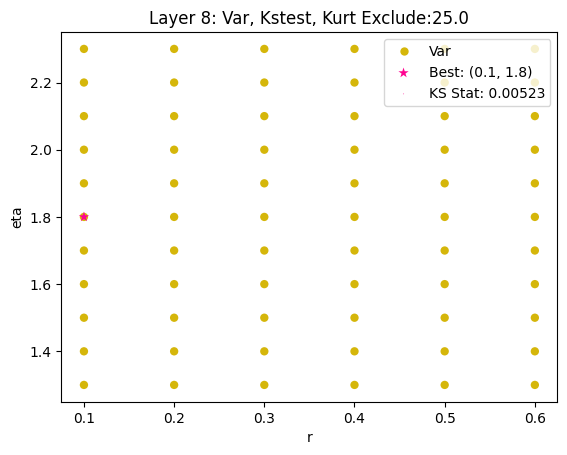

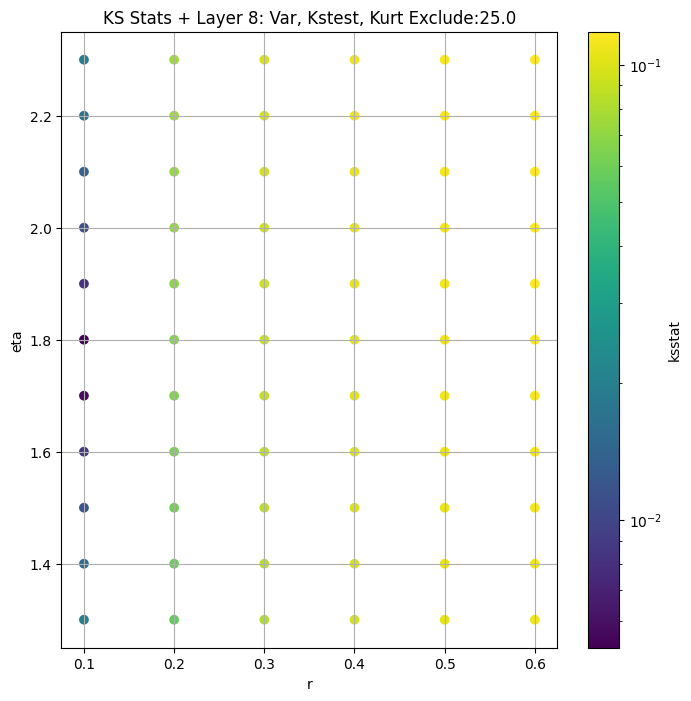

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,1905.932900,1698.254500,2134.568000,4.313463,2.497993,6.197537,3180.0,0.019601,0.2,3.2,1.781373e-04,0.0,1905.932900,0.024030
3,610.390870,574.298700,648.551900,3.674140,2.805851,4.680453,12720.0,0.003151,0.3,1.5,1.983566e-01,0.0,610.390870,0.012029
4,172.283200,161.497960,183.496800,4.112916,3.268325,5.234512,50880.0,0.005569,0.5,0.0,1.387089e+01,25.0,166.450680,0.006018
5,40.234180,37.397793,43.230920,5.987719,4.644133,7.689358,203520.0,0.002663,0.5,-0.4,5.461936e+00,50.0,38.452030,0.003010
6,8.033402,7.378767,8.728930,8.447668,6.249308,11.777606,814080.0,0.003849,0.4,-0.5,4.205551e-01,50.0,7.592730,0.001505
7,1.504845,1.368442,1.653126,11.570850,8.417268,17.668781,3256320.0,0.004634,0.2,0.0,2.057789e-05,0.0,1.504845,0.000753
8,0.248263,0.222952,0.278427,16.534340,10.476642,35.571274,13025280.0,0.005234,0.1,1.8,4.407315e-17,25.0,0.235332,0.000376


In [33]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [34]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 621/621 [00:00<00:00, 2323.76it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.04885080086617666, var: 1024.1884765625


100%|██████████| 621/621 [00:00<00:00, 7252.20it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.03934300964948634, var: 1133.2681884765625


100%|██████████| 621/621 [00:00<00:00, 3932.52it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.031325666150333276, var: 1273.488037109375


100%|██████████| 621/621 [00:00<00:00, 6772.83it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.023104847643478976, var: 1457.8974609375


100%|██████████| 621/621 [00:00<00:00, 7248.10it/s]


Finding Minimum after computing 621 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01960099603216159, var: 1905.932861328125
Number of samples: 3180, Without approximation : 3180.0


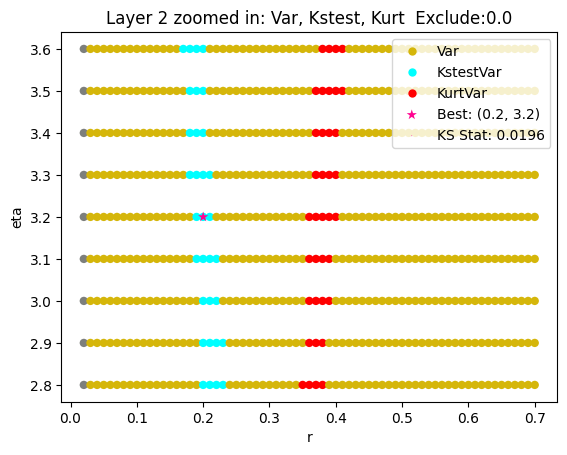

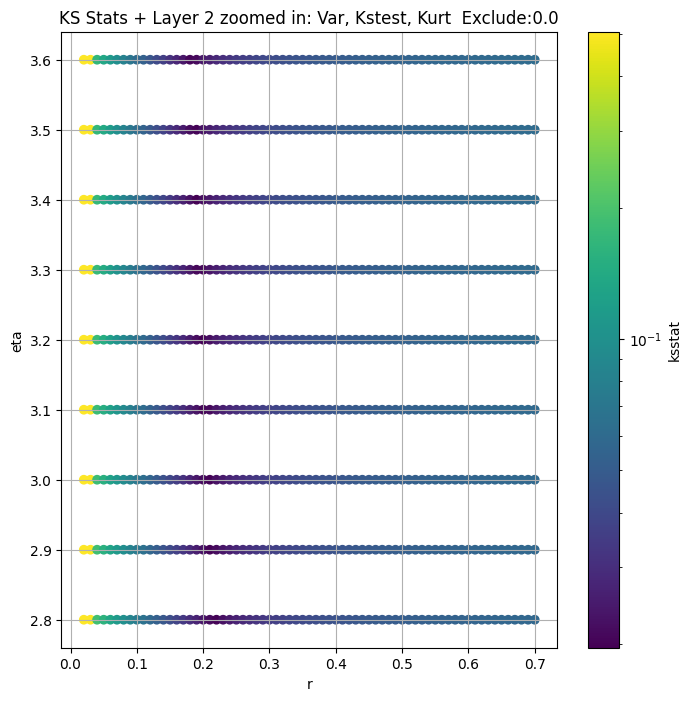

Layer 3


100%|██████████| 702/702 [00:00<00:00, 1279.91it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.014700992798852175, var: 474.83642578125


100%|██████████| 702/702 [00:00<00:00, 2234.43it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.012140891235056794, var: 496.366455078125


100%|██████████| 702/702 [00:00<00:00, 2228.33it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.009561895807320697, var: 521.7076416015625


100%|██████████| 702/702 [00:00<00:00, 2165.36it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.00670438710096477, var: 553.5939331054688


100%|██████████| 702/702 [00:00<00:00, 2230.68it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.003042048727539326, var: 610.390869140625
Number of samples: 12720, Without approximation : 12720.0


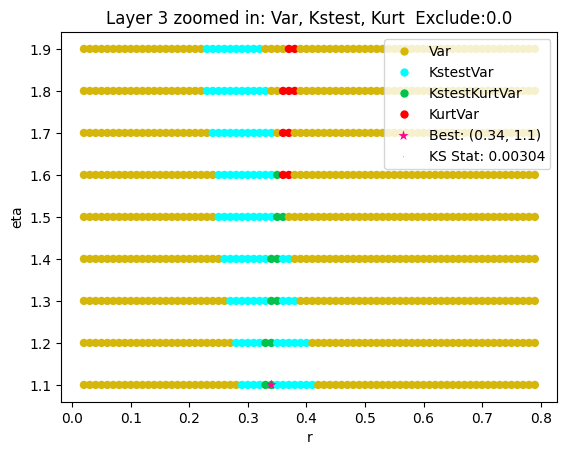

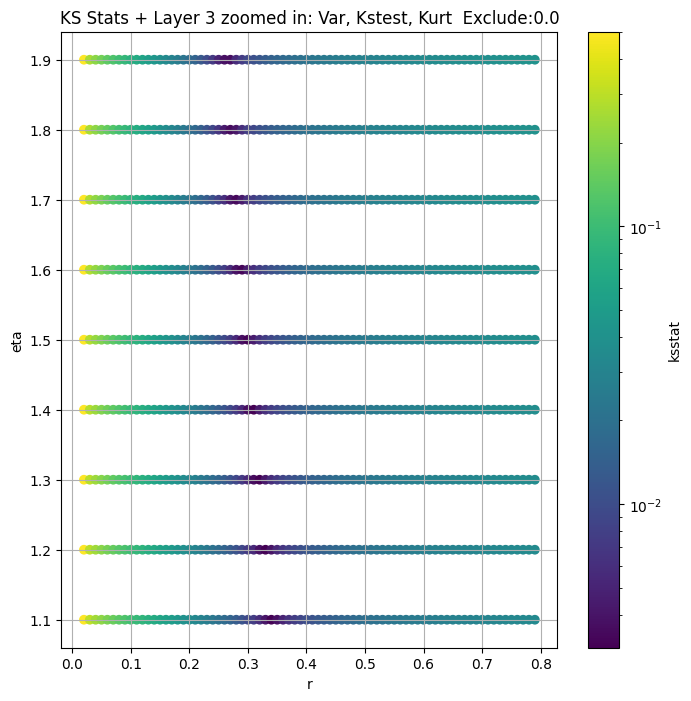

Layer 4


100%|██████████| 1287/1287 [00:02<00:00, 488.40it/s]


Finding Minimum after computing 1287 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.0064426163660338265, var: 153.5129852294922


100%|██████████| 1287/1287 [00:02<00:00, 595.62it/s]


Finding Minimum after computing 1287 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.00581475749112792, var: 156.19332885742188


100%|██████████| 1287/1287 [00:02<00:00, 546.47it/s]


Finding Minimum after computing 1287 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.005505255898913097, var: 159.10963439941406


100%|██████████| 1287/1287 [00:02<00:00, 589.43it/s]


Finding Minimum after computing 1287 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.005463061686327153, var: 162.44105529785156


100%|██████████| 1287/1287 [00:02<00:00, 545.07it/s]


Finding Minimum after computing 1287 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.005522284604554506, var: 166.45068359375


100%|██████████| 1287/1287 [00:02<00:00, 577.11it/s]


Finding Minimum after computing 1287 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.005465595971629877, var: 172.283203125
Number of samples: 50880, Without approximation : 50880.0


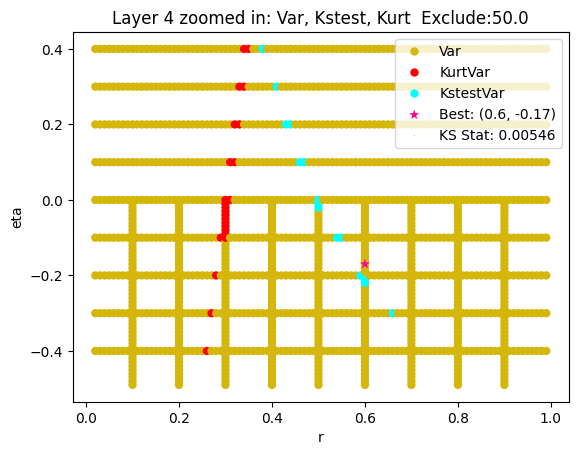

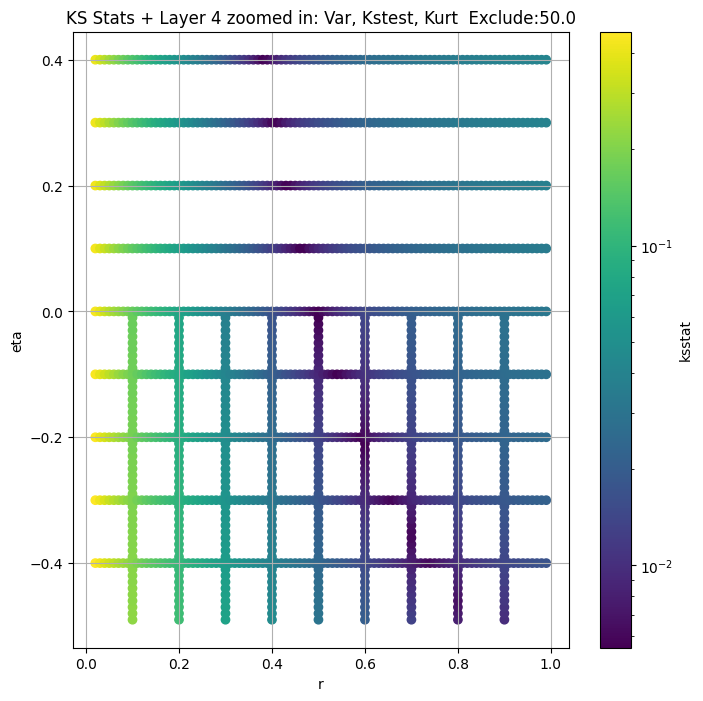

Layer 5


100%|██████████| 1611/1611 [00:05<00:00, 284.67it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.003930962501705992, var: 36.35390090942383


100%|██████████| 1611/1611 [00:05<00:00, 300.01it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.0035300189972513607, var: 36.803016662597656


100%|██████████| 1611/1611 [00:05<00:00, 294.25it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.0032112226212368533, var: 37.29652786254883


100%|██████████| 1611/1611 [00:05<00:00, 293.87it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.0028145293147618933, var: 37.84600067138672


100%|██████████| 1611/1611 [00:05<00:00, 300.12it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.002389576782789865, var: 38.452030181884766


100%|██████████| 1611/1611 [00:05<00:00, 304.00it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0019030318301546112, var: 39.17844772338867


100%|██████████| 1611/1611 [00:05<00:00, 290.63it/s]


Finding Minimum after computing 1611 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.001755757327753682, var: 40.23418045043945
Number of samples: 100000, Without approximation : 203520.0


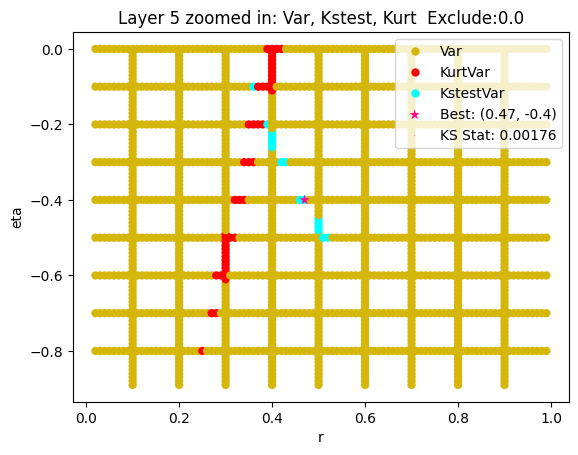

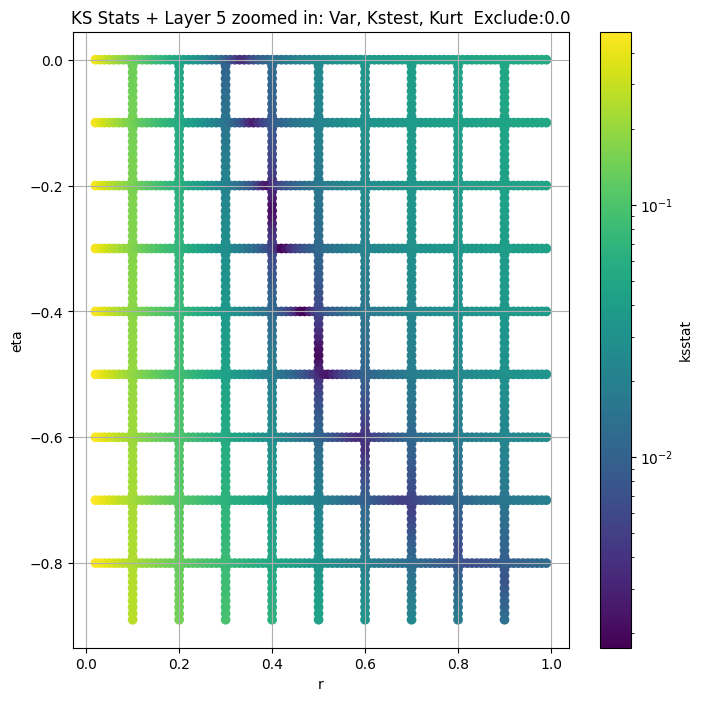

Layer 6


100%|██████████| 1512/1512 [00:05<00:00, 299.23it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.004420171171629184, var: 7.105913162231445


100%|██████████| 1512/1512 [00:05<00:00, 298.60it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.00422513517109413, var: 7.210117816925049


100%|██████████| 1512/1512 [00:05<00:00, 298.15it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.003749307796831247, var: 7.323657512664795


100%|██████████| 1512/1512 [00:05<00:00, 300.74it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.0035430262375164556, var: 7.449450492858887


100%|██████████| 1512/1512 [00:05<00:00, 297.32it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.0032712989728548303, var: 7.5927300453186035


100%|██████████| 1512/1512 [00:04<00:00, 304.30it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.002866584490914592, var: 7.764286994934082


100%|██████████| 1512/1512 [00:05<00:00, 298.40it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.0026803711360197102, var: 8.033401489257812
Number of samples: 100000, Without approximation : 814080.0


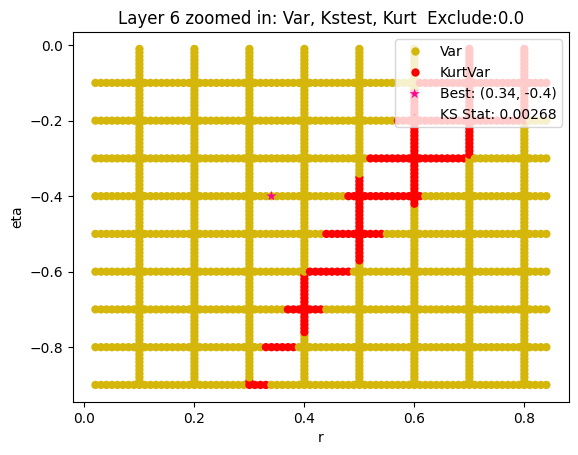

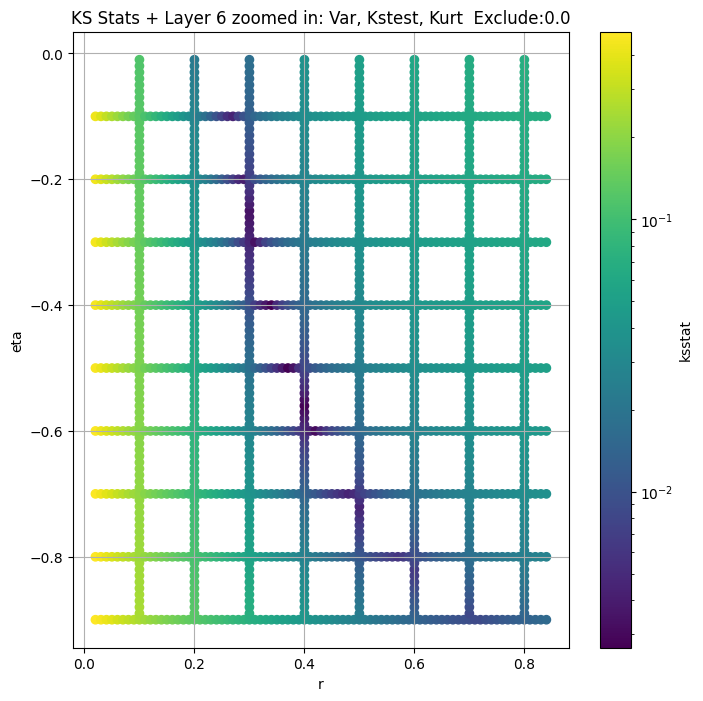

Layer 7


100%|██████████| 936/936 [00:03<00:00, 296.99it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.005558838765682306, var: 1.348076581954956


100%|██████████| 936/936 [00:03<00:00, 301.70it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.005050131964188576, var: 1.3753308057785034


100%|██████████| 936/936 [00:03<00:00, 292.08it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.004519313393399782, var: 1.4065442085266113


100%|██████████| 936/936 [00:03<00:00, 297.63it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.004682741217543918, var: 1.4443918466567993


100%|██████████| 936/936 [00:03<00:00, 305.13it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.0037374231566977834, var: 1.5048452615737915
Number of samples: 100000, Without approximation : 3256320.0


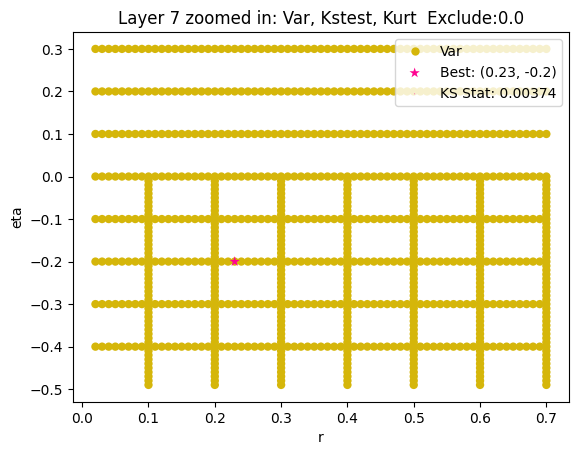

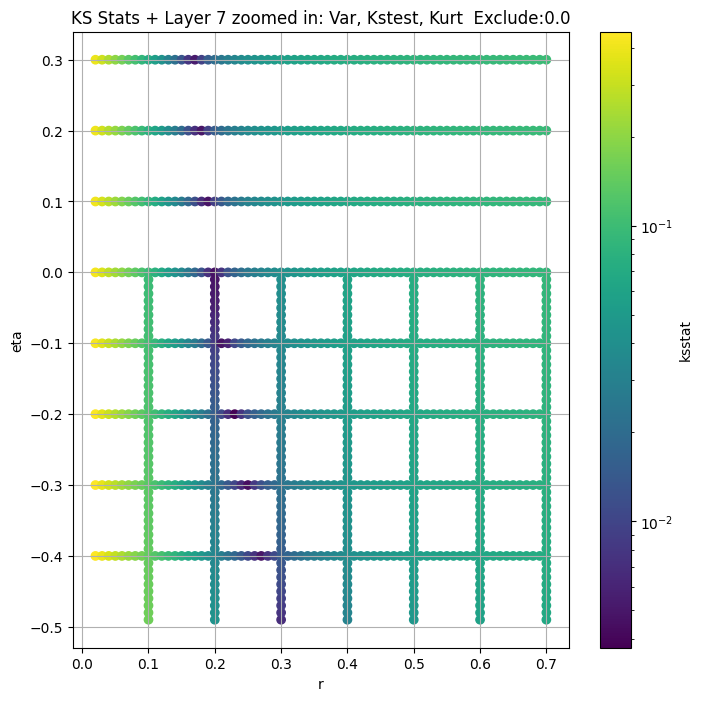

Layer 8


100%|██████████| 580/580 [00:02<00:00, 264.00it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.006730875562836691, var: 0.21245625615119934


100%|██████████| 580/580 [00:02<00:00, 249.34it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.00602555406993277, var: 0.2169831395149231


100%|██████████| 580/580 [00:02<00:00, 279.34it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.005688522661363882, var: 0.22208037972450256


100%|██████████| 580/580 [00:02<00:00, 281.50it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.0051768526071374055, var: 0.22799238562583923


100%|██████████| 580/580 [00:01<00:00, 304.43it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.0049353373193025685, var: 0.23533178865909576


100%|██████████| 580/580 [00:01<00:00, 304.41it/s]


Finding Minimum after computing 580 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.004957671759793836, var: 0.24826277792453766
Number of samples: 100000, Without approximation : 13025280.0


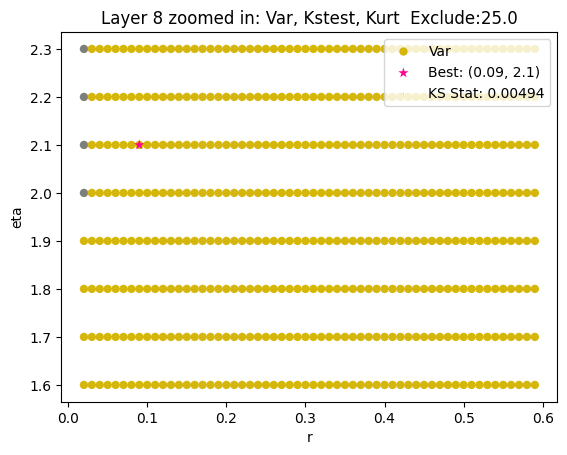

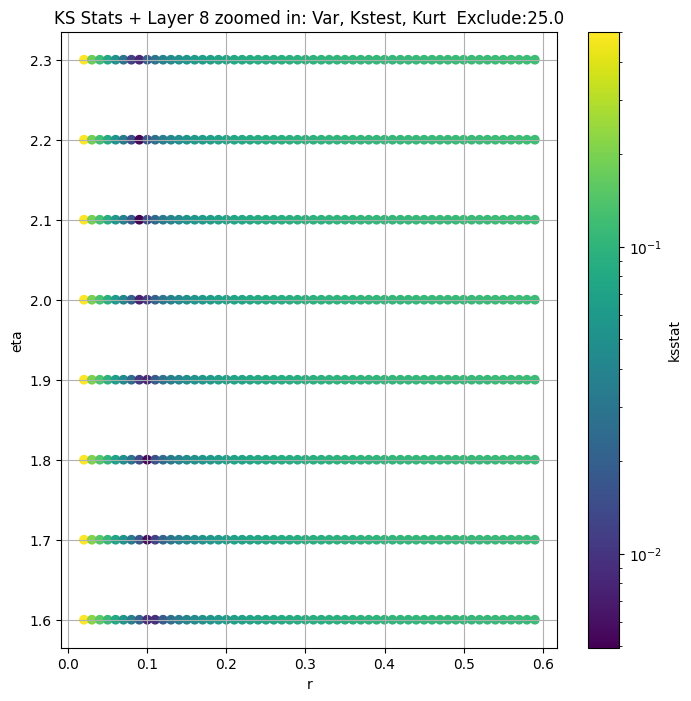

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,1905.932900,1698.254500,2134.568000,4.313463,2.497993,6.197537,3180.0,0.019601,0.2,3.2,1.781373e-04,0.0,1905.932900,0.024030,0.019601,0.20,3.20,1.781373e-04,0.0,4770
3,610.390870,574.298700,648.551900,3.674140,2.805851,4.680453,12720.0,0.003151,0.3,1.5,1.983566e-01,0.0,610.390869,0.012029,0.003042,0.34,1.10,1.096435e+00,0.0,206293
4,172.283200,161.497960,183.496800,4.112916,3.268325,5.234512,50880.0,0.005569,0.5,0.0,1.387089e+01,25.0,162.441055,0.006018,0.005463,0.60,-0.17,3.478715e+01,50.0,64395
5,40.234180,37.397793,43.230920,5.987719,4.644133,7.689358,203520.0,0.002663,0.5,-0.4,5.461936e+00,50.0,40.234180,0.003010,0.001756,0.47,-0.40,4.323501e+00,0.0,579555
6,8.033402,7.378767,8.728930,8.447668,6.249308,11.777606,814080.0,0.003849,0.4,-0.5,4.205551e-01,50.0,8.033401,0.001505,0.002680,0.34,-0.40,1.240746e-01,0.0,257580
7,1.504845,1.368442,1.653126,11.570850,8.417268,17.668781,3256320.0,0.004634,0.2,0.0,2.057789e-05,0.0,1.504845,0.000753,0.003737,0.23,-0.20,2.780049e-04,0.0,128790
8,0.248263,0.222952,0.278427,16.534340,10.476642,35.571274,13025280.0,0.005234,0.1,1.8,4.407315e-17,25.0,0.235332,0.000376,0.004935,0.09,2.10,1.020663e-19,25.0,76320


In [35]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [36]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

RejectedExecutionError: MATLAB has already terminated

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,1696.189600,1517.783900,1889.853600,3.796600,2.353942,5.295139,3180.0,0.017226,0.1,8.7,...,32.943400,0.032992,1.925360e-03,30.544800,0.022702,7.426860e-02,25.284700,0.018571,2.200210e-01,2.985306e-01
3,546.266700,515.087160,579.062300,3.272476,2.555443,4.080620,12720.0,0.003994,0.3,1.6,...,19.278300,0.026266,4.675180e-08,16.696100,0.008254,3.495940e-01,13.636900,0.011845,5.590880e-02,9.918518e-01
4,154.462460,145.019270,164.261180,3.816736,3.066599,4.774097,50880.0,0.005708,0.6,-0.1,...,9.585560,0.032821,4.729710e-48,8.430870,0.006066,4.711630e-02,6.901150,0.009433,2.323800e-04,9.569157e-02
5,35.853176,33.392532,38.437500,5.541130,4.382674,6.967747,203520.0,0.002086,0.4,-0.2,...,4.246750,0.037929,7.965330e-255,3.722800,0.010595,2.845330e-20,3.004420,0.013621,3.143460e-33,5.892270e-01
6,7.102549,6.540381,7.693819,7.751813,5.927745,10.394491,814080.0,0.004030,0.4,-0.5,...,1.671520,0.047234,0.000000e+00,1.464350,0.019746,3.784750e-276,1.172610,0.021799,0.000000e+00,6.544400e-12
7,1.320503,1.204313,1.445969,10.719652,8.014826,15.655435,3256320.0,0.009590,0.2,0.0,...,0.635292,0.054471,0.000000e+00,0.557946,0.027110,0.000000e+00,0.443521,0.027202,0.000000e+00,1.497431e-260
8,0.216768,0.195278,0.241856,15.263584,9.907603,31.192720,13025280.0,0.029580,0.3,-0.4,...,0.245468,0.054655,0.000000e+00,0.213079,0.029580,0.000000e+00,0.165991,0.030698,0.000000e+00,0.000000e+00


## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,0.017226,0.024030,0.017226,0.032992,0.022702,0.018571
3,0.003994,0.012029,0.003831,0.026266,0.008254,0.011845
4,0.005708,0.006018,0.005462,0.032821,0.006066,0.009433
5,0.002086,0.003010,0.001712,0.037929,0.010595,0.013621
6,0.004030,0.001505,0.004030,0.047234,0.019746,0.021799
7,0.009590,0.000753,0.009590,0.054471,0.027110,0.027202
8,0.029580,0.000376,0.029580,0.054655,0.029580,0.030698


In [ ]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,1696.189600,0.017226,0.10,8.70,9.068987e-18,0.0
3,546.266724,0.003831,0.33,1.30,6.020135e-01,0.0
4,143.244431,0.005462,0.74,-0.30,6.579433e+01,75.0
5,35.853176,0.001712,0.50,-0.43,5.335612e+00,0.0
6,6.885983,0.004030,0.45,-0.60,8.621942e-01,25.0
7,1.189371,0.009590,0.23,-0.10,1.698345e-04,100.0
8,0.194967,0.029580,0.56,-0.80,8.547308e-02,75.0


In [ ]:
eng.quit()